Lefki Ioanna (Eleanna) Panagiotou 

ID: 908 589 7206

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.metrics import  auc, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from scipy.optimize import linear_sum_assignment
from scipy.stats import multivariate_normal
import scipy.linalg

from tqdm.auto import tqdm

## 1.2

### Generating datasets

In [91]:
def generate_data(sigma):
    samples_per_distr = 100
    
    # Mean and covariance matrices for the three distributions
    mean_a = np.array([-1, -1])
    cov_a = sigma * np.array([[2, 0.5], [0.5, 1]])

    mean_b = np.array([1, -1])
    cov_b = sigma * np.array([[1, -0.5], [-0.5, 2]])

    mean_c = np.array([0, 1])
    cov_c = sigma * np.array([[1, 0], [0, 2]])

    # Generate data points for each distribution
    data_a = np.random.multivariate_normal(mean_a, cov_a, samples_per_distr)
    data_b = np.random.multivariate_normal(mean_b, cov_b, samples_per_distr)
    data_c = np.random.multivariate_normal(mean_c, cov_c, samples_per_distr)

    # Stack the data points to create the complete dataset
    data = np.concatenate([data_a, data_b, data_c])
    true_labels = ['a'] * len(data_a) + ['b'] * len(data_b) + ['c'] * len(data_c)
    
    return data, true_labels

### Implementing K-means

In [92]:
def smart_centroids_init(data, k):
    
    centroids = [data[np.random.randint(0, data.shape[0])]]
    
    for _ in range(1, k):
        distances = np.array([min([np.linalg.norm(x - c) ** 2 for c in centroids]) for x in data])
        next_centroid = data[np.random.choice(len(data), p=distances / distances.sum())]
        centroids.append(next_centroid)

    return np.array(centroids)

In [93]:
def my_Kmeans(data, k, init_type=None):
    
    if init_type == 'smart':
        initial_centroids = smart_centroids_init(data, k)
    else:
        initial_centroids = data[np.random.choice(data.shape[0], k, replace=False)]
    
    max_iters=1000
    labels = np.zeros(data.shape[0], dtype=int)
    
    for iteration in range(max_iters):
        distances = np.linalg.norm(data[:, np.newaxis] - initial_centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(0,k)])

        if np.all(new_centroids == initial_centroids):
            break

        initial_centroids = new_centroids

    final_labels = [x + 1 for x in labels]
    final_centroids = new_centroids
    
    return final_centroids, final_labels

In [94]:
def calculate_obj(data, centroids, labels):
    
    obj_val = 0
    
    for i in range(1, len(centroids)+1):
        cluster_points = data[np.where(labels == i)]
        obj_val += np.sum((cluster_points - centroids[i-1])**2)
      
        
    return obj_val

In [95]:
def Kmeans_mapping(predicted_centroids, predicted_labels):
    # Generate ground truth centroids and algorithm-generated centroids
    # You should have these from your K-means or GMM results
    ground_truth_centroids = np.array([[-1, -1], [1, -1], [0, 1]])
    algorithm_centroids = predicted_centroids  # Replace with your actual centroids

    # Define the true distribution labels and cluster labels
    true_labels = ['a', 'b', 'c']
    cluster_labels = [1, 2, 3]

    # Calculate the distance matrix between ground truth and algorithm centroids
    distance_matrix = pairwise_distances(ground_truth_centroids, algorithm_centroids)

    # Use the Hungarian algorithm to find the best centroid mapping
    row_ind, col_ind = linear_sum_assignment(distance_matrix)

    # Create a mapping from algorithm-generated cluster IDs to true distribution labels
    cluster_to_label_mapping = {cluster_labels[i]: true_labels[col_ind[i]] for i in range(len(cluster_labels))}
    
    labels = [cluster_to_label_mapping[cluster] for cluster in predicted_labels]
    
    return labels

In [96]:
np.random.seed(42)
sigmas = [0.5, 1.0, 2.0, 4.0, 8.0]
k = 3
kmeans_objectives = []
kmeans_accuracies = []

for sigma in sigmas:
    
    data, true_labels = generate_data(sigma)
    predicted_centroids, predicted_labels = my_Kmeans(data, k, 'smart')
    
    obj_val = calculate_obj(data, predicted_centroids, np.array(predicted_labels))
    print("Objective value:", obj_val)
    kmeans_objectives.append(obj_val)
    
    predicted_labels = Kmeans_mapping(predicted_centroids, predicted_labels)
    
    accuracy = sum(true_label == predicted_label for true_label, predicted_label in zip(true_labels, predicted_labels)) / len(data) * 100
    print("Clustering Accuracy for All Data Points: {:.2f}%".format(accuracy))
    kmeans_accuracies.append(accuracy)

Objective value: 301.1127968441795
Clustering Accuracy for All Data Points: 81.33%
Objective value: 568.3125818618742
Clustering Accuracy for All Data Points: 69.67%
Objective value: 951.0924299362367
Clustering Accuracy for All Data Points: 60.00%
Objective value: 1924.6594115154953
Clustering Accuracy for All Data Points: 49.33%
Objective value: 3304.427695975483
Clustering Accuracy for All Data Points: 44.67%


### Implementing EM

In [97]:
def e_step(data, means, covariances, weights):
    n_samples = data.shape[0]
    responsibilities = np.zeros((n_samples, len(means)))

    for i in range(len(means)):
        responsibilities[:, i] = weights[i] * multivariate_normal.pdf(data, means[i], covariances[i])

    responsibilities /= np.sum(responsibilities, axis=1, keepdims=True)

    return responsibilities

In [98]:
def m_step(data, responsibilities):
    n_samples, n_features = data.shape
    new_weights = np.mean(responsibilities, axis=0)
    new_means = np.dot(responsibilities.T, data) / np.sum(responsibilities, axis=0)[:, np.newaxis]
    new_covariances = []

    for i in range(len(new_means)):
        diff = data - new_means[i]
        cov_matrix = np.dot(responsibilities[:, i] * diff.T, diff) / np.sum(responsibilities[:, i])
        new_covariances.append(cov_matrix)

    return new_means, new_covariances, new_weights

In [99]:
def negative_log_likelihood(data, means, covariances, weights):
    n_samples = data.shape[0]
    log_likelihood = np.zeros(n_samples)

    for i in range(len(means)):
        log_likelihood += weights[i] * multivariate_normal.pdf(data, means[i], covariances[i])

    return -np.sum(np.log(log_likelihood))

In [100]:
def GMM_mapping(predicted_means, predicted_labels):
    ground_truth_means = {
        'a': np.array([-1, -1]),
        'b': np.array([1, -1]),
        'c': np.array([0, 1])
    }

    true_labels = ['a', 'b', 'c']
    cluster_labels = [1, 2, 3]

    # Calculate the distance matrix between ground truth and algorithm means
    distance_matrix = np.zeros((len(true_labels), len(cluster_labels)))
    
    for i, true_label in enumerate(true_labels):
        for j, cluster_label in enumerate(cluster_labels):
            distance_matrix[i, j] = np.linalg.norm(ground_truth_means[true_label] - predicted_means[cluster_label-1])

    #Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(distance_matrix)

    # Create a mapping from algorithm-generated cluster IDs to true distribution labels
    cluster_to_label_mapping = {cluster_labels[col_ind[i]]: true_labels[i] for i in range(len(true_labels))}
    
    mapped_labels = [cluster_to_label_mapping[label] for label in predicted_labels]
    
    return mapped_labels

In [101]:
def my_GMM(data, n_components, tol=1e-4):
    n_samples, n_features = data.shape

    means = data[np.random.choice(n_samples, n_components, replace=False)]
    covariances = [np.eye(n_features)] * n_components
    weights = np.ones(n_components) / n_components

    means = np.array(means)  
    covariances = np.array(covariances)
    
    predicted_labels = None
    max_iters = 1000
    for _ in range(max_iters):
        # E-step
        responsibilities = e_step(data, means, covariances, weights)
        
        predicted_labels = np.argmax(responsibilities, axis=1)
        
        # M-step
        new_means, new_covariances, new_weights = m_step(data, responsibilities)

        means = new_means
        covariances = new_covariances
        weights = new_weights
        predicted_labels = [x + 1 for x in predicted_labels]

    return means, covariances, weights, predicted_labels

In [102]:
np.random.seed(42)

sigmas = [0.5, 1.0, 2.0, 4.0, 8.0]
k = 3
em_objectives = []
em_accuracies = []

for sigma in sigmas:
    
    data, true_labels = generate_data(sigma)
    predicted_means, covariances, weights, predicted_labels = my_GMM(data, k)
    
    obj_val = negative_log_likelihood(data, predicted_means, covariances, weights)
    print("Objective value:", obj_val)
    em_objectives.append(obj_val)
    
    predicted_labels = GMM_mapping(predicted_means, predicted_labels)
    
    accuracy = sum(true_label == predicted_label for true_label, predicted_label in zip(true_labels, predicted_labels)) / len(data) * 100
    print("Clustering Accuracy for All Data Points: {:.2f}%".format(accuracy))
    em_accuracies.append(accuracy)

Objective value: 903.1181122932736
Clustering Accuracy for All Data Points: 79.33%
Objective value: 1070.0070392871398
Clustering Accuracy for All Data Points: 53.67%
Objective value: 1235.7821400637931
Clustering Accuracy for All Data Points: 45.67%
Objective value: 1438.3912320003521
Clustering Accuracy for All Data Points: 40.33%
Objective value: 1612.185494044604
Clustering Accuracy for All Data Points: 39.00%


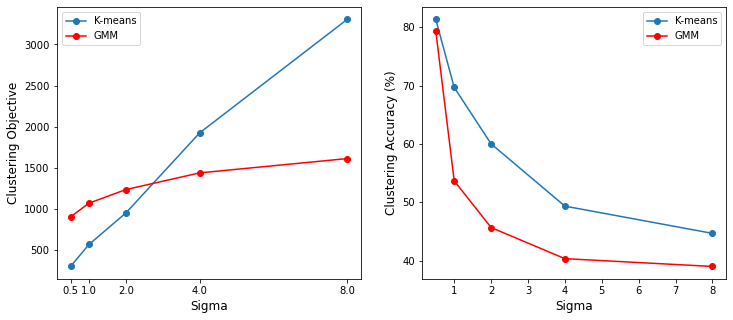

In [103]:
# Plot the results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(sigmas, kmeans_objectives, '-o', label='K-means')
plt.plot(sigmas, em_objectives,'-ro', label='GMM')
plt.xlabel('Sigma', fontsize=12)
plt.ylabel('Clustering Objective', fontsize=12)
plt.xticks(sigmas)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(sigmas, kmeans_accuracies, '-o', label='K-means')
plt.plot(sigmas, em_accuracies, '-ro', label='GMM')
plt.xlabel('Sigma', fontsize=12)
plt.ylabel('Clustering Accuracy (%)', fontsize=12)
plt.legend()

plt.show()

## 2.3

In [57]:
def buggy_pca(X, d):
    
    U, S, V = np.linalg.svd(X)
    Z = np.dot(X, V[:d, :].T)
    reconstructions = np.dot(Z, V[:d, :])
    
    return Z, V[:, :d], reconstructions

In [58]:
def demeaned_pca(X, d):
    params = []
    mean = np.mean(X, axis=0)
    X_demeaned = X - mean
    
    Z, A, reconstructions = buggy_pca(X_demeaned, d)
    
    reconstructions = reconstructions + mean
    
    params.append(mean)
    return Z, params, reconstructions

In [59]:
def normalized_pca(X, d):
    
    params = []
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    
    X_normalized = (X - mean) / std
    
    Z, A, reconstructions = buggy_pca(X_normalized, d)
    
    reconstructions = reconstructions * std + mean
    
    params.append(mean)
    params.append(std)
    
    return Z, params, reconstructions

In [60]:
def DRO(X, d):   
    params = []
    n = X.shape[0]
    b = np.mean(X, axis=0)
    
    U, S, Vt = np.linalg.svd(X - b, full_matrices=False)
    Ud = U[:, :d]
    Sd = np.diag(S[:d])
    Vd = Vt[:d, :].T
    
    A = ((1 / np.sqrt(n)) * np.dot(Sd, Vd.T)).T
    Z = np.sqrt(n) * Ud
    
    reconstructions = Z.dot(A.T) + b
    
    params.append(A)
    params.append(b)
    
    return Z, params, reconstructions

In [61]:
def reconstruction_error(original, reconstructed):
    return np.sum((original - reconstructed) ** 2)

### 2D data

In [68]:
data2D = np.loadtxt("C:/Users/lefki/Documents/MyDesktop/Master/Semester 1/ECE 760/HW5/data/data2D.csv", delimiter=",")

In [69]:
# Calculate representations, parameters, and reconstructions for all methods
Z_buggy, params, reconstructions_buggy = buggy_pca(data2D, 1)
print(params.shape)
Z_demeaned, params, reconstructions_demeaned = demeaned_pca(data2D, 1)
Z_normalized, params, reconstructions_normalized = normalized_pca(data2D, 1)
Z_dro, params, reconstructions_dro = DRO(data2D, 1)

error_buggy = reconstruction_error(data2D, reconstructions_buggy)
error_demeaned = reconstruction_error(data2D, reconstructions_demeaned)
error_normalized = reconstruction_error(data2D, reconstructions_normalized)
error_dro = reconstruction_error(data2D, reconstructions_dro)

print("\033[1m2D data")
print("\033[0mReconstruction Error (Buggy PCA):", error_buggy)
print("Reconstruction Error (Demeaned PCA):", error_demeaned)
print("Reconstruction Error (Normalized PCA):", error_normalized)
print("Reconstruction Error (DRO):", error_dro)

2D data
Reconstruction Error (Buggy PCA): 44.34515418673971
Reconstruction Error (Demeaned PCA): 0.500304281425646
Reconstruction Error (Normalized PCA): 2.473604172738534
Reconstruction Error (DRO): 0.500304281425646


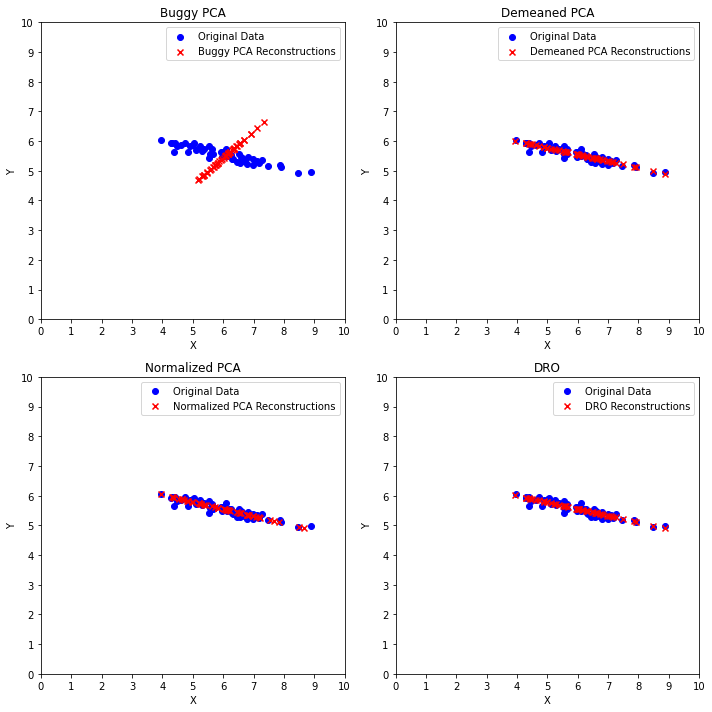

In [71]:
# Original data
x_original = data2D[:, 0]
y_original = data2D[:, 1]

# Buggy PCA reconstructions
x_buggy = reconstructions_buggy[:, 0]
y_buggy = reconstructions_buggy[:, 1]

# Demeaned PCA reconstructions
x_demeaned = reconstructions_demeaned[:, 0]
y_demeaned = reconstructions_demeaned[:, 1]

# Normalized PCA reconstructions
x_normalized = reconstructions_normalized[:, 0]
y_normalized = reconstructions_normalized[:, 1]

x_dro = reconstructions_dro[:, 0]
y_dro = reconstructions_dro[:, 1]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].scatter(x_original, y_original, label="Original Data", marker='o', color='blue')
axes[0, 0].scatter(x_buggy, y_buggy, label="Buggy PCA Reconstructions", marker='x', color='red')
axes[0, 0].set_title("Buggy PCA")
axes[0, 0].set_xticks(np.arange(0, 11))
axes[0, 0].set_yticks(np.arange(0, 11))

axes[0, 1].scatter(x_original, y_original, label="Original Data", marker='o', color='blue')
axes[0, 1].scatter(x_demeaned, y_demeaned, label="Demeaned PCA Reconstructions", marker='x', color='red')
axes[0, 1].set_title("Demeaned PCA")
axes[0, 1].set_xticks(np.arange(0, 11))
axes[0, 1].set_yticks(np.arange(0, 11))

axes[1, 0].scatter(x_original, y_original, label="Original Data", marker='o', color='blue')
axes[1, 0].scatter(x_normalized, y_normalized, label="Normalized PCA Reconstructions", marker='x', color='red')
axes[1, 0].set_title("Normalized PCA")
axes[1, 0].set_xticks(np.arange(0, 11))
axes[1, 0].set_yticks(np.arange(0, 11))

axes[1, 1].scatter(x_original, y_original, label="Original Data", marker='o', color='blue')
axes[1, 1].scatter(x_dro, y_dro, label="DRO Reconstructions", marker='x', color='red')
axes[1, 1].set_title("DRO")
axes[1, 1].set_xticks(np.arange(0, 11))
axes[1, 1].set_yticks(np.arange(0, 11))

axes[0, 0].legend()
axes[0, 1].legend()
axes[1, 0].legend()
axes[1, 1].legend()

for ax in axes.flat:
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

plt.tight_layout()
plt.show()

### 1000D data

In [72]:
data1000D = np.loadtxt("C:/Users/lefki/Documents/MyDesktop/Master/Semester 1/ECE 760/HW5/data/data1000D.csv", delimiter=",")
print(data1000D.shape)

(500, 1000)


In [108]:
def choose_d_svd(X):
    mean = np.mean(X, axis=0)
    X = X - mean
    
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[1].plot(S)
    axes[1].set_xlabel("Index = d-1", fontsize=13)
    axes[1].set_ylabel("Singular Value", fontsize=13)
    axes[1].set_xlim((28, 32))
    axes[1].grid(True)

    axes[0].plot(S)
    axes[0].set_xlabel("Index = d-1", fontsize=13)
    axes[0].set_ylabel("Singular Value", fontsize=13)
    axes[0].set_xlim((0, 500))
    axes[0].grid(True)

    # Adjust spacing between subplots for better readability
    plt.tight_layout()

    # Show the plots
    plt.show()
    
    return S

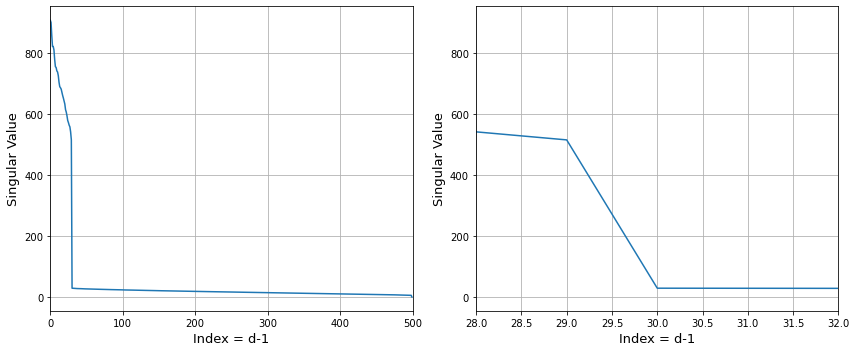

In [109]:
d_1000D = choose_d_svd(data1000D)

In [85]:
Z_buggy, params, reconstructions_buggy = buggy_pca(data1000D, d=30)
Z_demeaned, params, reconstructions_demeaned = demeaned_pca(data1000D, d=30)
Z_normalized, params, reconstructions_normalized = normalized_pca(data1000D, d=30)
Z_dro, params, reconstructions_dro = DRO(data1000D, d=30)

error_buggy = reconstruction_error(data1000D, reconstructions_buggy)
error_demeaned = reconstruction_error(data1000D, reconstructions_demeaned)
error_normalized = reconstruction_error(data1000D, reconstructions_normalized)
error_dro = reconstruction_error(data1000D, reconstructions_dro)

print("\033[1m1000D data")
print("\033[0mReconstruction Error (Buggy PCA):", error_buggy)
print("Reconstruction Error (Demeaned PCA):", error_demeaned)
print("Reconstruction Error (Normalized PCA):", error_normalized)
print("Reconstruction Error (DRO):", error_dro)

1000D data
Reconstruction Error (Buggy PCA): 401365.6993101792
Reconstruction Error (Demeaned PCA): 136522.9794893014
Reconstruction Error (Normalized PCA): 136814.2904988116
Reconstruction Error (DRO): 136522.9794893014
